# Module 4b: Your First Water Modelling Script
## Analyzing Real Discharge Data

**Time required:** 40-50 minutes  
**Prerequisites:** Module 4a (data downloaded)  
**What you'll do:** Load, analyze, and visualize real hydrological data

## What We'll Build

In this module, you'll analyze the discharge data you downloaded in Module 4a. We'll:

1. **Load** discharge data from the CSV file
2. **Check** data quality (missing values, date ranges)
3. **Calculate** hydrological statistics (mean, percentiles, monthly values)
4. **Identify** high and low flow events
5. **Create** professional hydrograph plots
6. **Generate** monthly distribution analysis
7. **Build** a flow duration curve (FDC)

This is real water modelling work—the kind of analysis you might do for a project or report.

### The Data

We'll use the CAMELS streamflow data you downloaded in Module 4a. The CSV file is in your `data/` folder and contains:
- Daily discharge values in m³/s
- Station metadata (ID and name)
- Date information for time series analysis

## Step 1: Check Your Data

Before we start the analysis, let's verify you have the data from Module 4a.

Your project should have:
- A `data/` folder with a CSV file like `camels_01013500_discharge.csv`
- The file contains columns: `date`, `discharge_m3s`, `station_id`, `station_name`

Let's check what files we have:

In [1]:
# Import the path helper we created in Module 4a
# This is saved in src/python_for_water_modellers/paths.py for reuse
from python_for_water_modellers import get_data_path

DATA_PATH = get_data_path()

# List available data files
print(f"Data path: {DATA_PATH}")
print(f"Data path exists: {DATA_PATH.exists()}")
if DATA_PATH.exists():
    data_files = [f.name for f in DATA_PATH.glob('*.csv')]
    print("CSV files in data/ folder:")
    for f in data_files:
        print(f"  {f}")

Data path: ../data
Data path exists: True
CSV files in data/ folder:
  camels_01013500_discharge.csv


You should see your downloaded CAMELS file listed. Note the filename—you'll need it in the next step.

## Step 2: Load and Explore Your Data

Let's start by loading the data and seeing what we have:

In [2]:
# CONFIGURATION - Update with your filename from Step 1
STATION_ID = '01013500'  # Change to your station ID
INPUT_FILE = DATA_PATH / f'camels_{STATION_ID}_discharge.csv'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Loading discharge data...")
print()

# Load the CSV file
df = pd.read_csv(INPUT_FILE)

# Display basic info
print(f"File: {INPUT_FILE}")
print(f"Rows: {len(df)}")
print(f"Columns: {list(df.columns)}")
print()
print("First few rows:")
print(df.head())
print()
print("Data types:")
print(df.dtypes)

Loading discharge data...

File: ../data/camels_01013500_discharge.csv
Rows: 12784
Columns: ['date', 'discharge_m3s', 'discharge_mm_day', 'station_id', 'station_name']

First few rows:
         date  discharge_m3s  discharge_mm_day  station_id  \
0  1980-01-01      18.547504          0.711371     1013500   
1  1980-01-02      18.122752          0.695080     1013500   
2  1980-01-03      17.698000          0.678789     1013500   
3  1980-01-04      17.556416          0.673358     1013500   
4  1980-01-05      17.131664          0.657067     1013500   

                       station_name  
0  Fish River Near Fort Kent, Maine  
1  Fish River Near Fort Kent, Maine  
2  Fish River Near Fort Kent, Maine  
3  Fish River Near Fort Kent, Maine  
4  Fish River Near Fort Kent, Maine  

Data types:
date                 object
discharge_m3s       float64
discharge_mm_day    float64
station_id            int64
station_name         object
dtype: object


**What to check:**
- Do you see the expected columns (`date`, `discharge_m3s`, etc.)?
- Is the date column recognized as text (object) for now? We'll convert it next.
- Does the data look reasonable?

If everything looks good, let's continue with the full analysis!

## Step 3: Complete Discharge Analysis

Now let's perform a complete discharge analysis. We'll break it into logical sections that you can run sequentially.

### Part 1: Prepare the Data for Analysis

Convert dates and set up the time series:

In [3]:
# Configuration
DATE_COLUMN = 'date'
DISCHARGE_COLUMN = 'discharge_m3s'

print("Preparing data for analysis...")
print()

# Convert date column to datetime format
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])

# Set date as the index for time-series operations
df.set_index(DATE_COLUMN, inplace=True)

# Get station name from the data
station_name = df['station_name'].iloc[0] if 'station_name' in df.columns else "Unknown Station"

# Report what we have
print(f"Station: {station_name}")
print(f"Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"Total records: {len(df)} days")

# Check for missing data
missing_count = df[DISCHARGE_COLUMN].isna().sum()
if missing_count > 0:
    missing_pct = missing_count / len(df) * 100
    print(f"Missing data: {missing_count} days ({missing_pct:.1f}%)")
else:
    print("No missing data")
print()
print("✓ Data prepared and ready for analysis")

Preparing data for analysis...

Station: Fish River Near Fort Kent, Maine
Period: 1980-01-01 to 2014-12-31
Total records: 12784 days
Missing data: 92 days (0.7%)

✓ Data prepared and ready for analysis


> 💡 **Why set the date as index?** This enables powerful time-series features like automatic date formatting on plots, easy resampling (daily → monthly), and simple date range selection: `df['2022-06':'2022-08']`

### Part 2: Calculate Flow Statistics

Calculate key hydrological statistics:

In [4]:
# =============================================================================
# LOAD AND PREPARE DATA
# =============================================================================

print("Loading data...")

# Read the CSV file into a DataFrame
df = pd.read_csv(INPUT_FILE)

# Convert date column to datetime format
# This allows pandas to understand these are dates, not just text
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])

# Set date as the index (row labels)
# This makes time-series operations much easier
df.set_index(DATE_COLUMN, inplace=True)

# Report what we loaded
print(f"  Loaded {len(df)} records")
print(f"  Period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")

# Check for missing data
missing_count = df[DISCHARGE_COLUMN].isna().sum()
if missing_count > 0:
    missing_pct = missing_count / len(df) * 100
    print(f"  Missing data: {missing_count} days ({missing_pct:.1f}%)")
else:
    print("  No missing data")
print()

Loading data...
  Loaded 12784 records
  Period: 1980-01-01 to 2014-12-31
  Missing data: 92 days (0.7%)



> **Why set the date as index?**
> 
> Setting the date as the DataFrame index enables powerful time-series features:
> - Automatic date formatting on plots
> - Easy resampling (daily → monthly)
> - Simple date range selection: `df['2022-06':'2022-08']`

### Part 3: Calculate Statistics

Now let's calculate key hydrological statistics:

In [5]:
# =============================================================================
# CALCULATE FLOW STATISTICS
# =============================================================================

print("Calculating statistics...")

# Get discharge series, excluding missing values
Q = df[DISCHARGE_COLUMN].dropna()

# Calculate key statistics
stats = {
    'Mean discharge (m³/s)': Q.mean(),
    'Median discharge (m³/s)': Q.median(),
    'Standard deviation (m³/s)': Q.std(),
    'Minimum (m³/s)': Q.min(),
    'Maximum (m³/s)': Q.max(),
    'Q10 - Low flow threshold (m³/s)': Q.quantile(0.10),
    'Q90 - High flow threshold (m³/s)': Q.quantile(0.90),
}

print()
print("FLOW STATISTICS")
print("-" * 45)
for name, value in stats.items():
    print(f"  {name:<35} {value:>8.2f}")
print()

Calculating statistics...

FLOW STATISTICS
---------------------------------------------
  Mean discharge (m³/s)                  43.76
  Median discharge (m³/s)                24.58
  Standard deviation (m³/s)              50.84
  Minimum (m³/s)                          1.19
  Maximum (m³/s)                        506.87
  Q10 - Low flow threshold (m³/s)         8.78
  Q90 - High flow threshold (m³/s)      105.62



> **What are Q10 and Q90?**
> 
> These are flow percentiles commonly used in hydrology:
> - **Q10**: Flow exceeded 90% of the time (low flow indicator)
> - **Q90**: Flow exceeded 10% of the time (high flow indicator)
> 
> Note: The naming convention varies. Some use Q10 for the 10th percentile, others for the flow exceeded 10% of time. Always clarify which convention you're using!

### Part 4: Identify Extreme Events

Find high and low flow periods:

In [6]:
# =============================================================================
# IDENTIFY EXTREME EVENTS
# =============================================================================

# Define thresholds using percentiles
threshold_high = Q.quantile(0.90)
threshold_low = Q.quantile(0.10)

# Find days exceeding thresholds
high_flow_days = df[df[DISCHARGE_COLUMN] > threshold_high]
low_flow_days = df[df[DISCHARGE_COLUMN] < threshold_low]

print("EXTREME EVENTS")
print("-" * 45)

# High flow summary
print(f"  High flow events (Q > {threshold_high:.1f} m³/s):")
print(f"    {len(high_flow_days)} days identified")
if len(high_flow_days) > 0:
    max_day = Q.idxmax()
    max_value = Q.max()
    print(f"    Maximum: {max_value:.1f} m³/s on {max_day.strftime('%Y-%m-%d')}")

print()

# Low flow summary
print(f"  Low flow events (Q < {threshold_low:.1f} m³/s):")
print(f"    {len(low_flow_days)} days identified")
if len(low_flow_days) > 0:
    min_day = Q.idxmin()
    min_value = Q.min()
    print(f"    Minimum: {min_value:.1f} m³/s on {min_day.strftime('%Y-%m-%d')}")
print()

EXTREME EVENTS
---------------------------------------------
  High flow events (Q > 105.6 m³/s):
    1264 days identified
    Maximum: 506.9 m³/s on 2008-04-30

  Low flow events (Q < 8.8 m³/s):
    1270 days identified
    Minimum: 1.2 m³/s on 1995-10-04



### Part 5: Monthly Summary

Calculate monthly statistics to see seasonal patterns:

In [7]:
# =============================================================================
# MONTHLY SUMMARY
# =============================================================================

# Resample to monthly and calculate statistics
# 'ME' means month end frequency
monthly = df[DISCHARGE_COLUMN].resample('ME').agg(['mean', 'min', 'max', 'std'])
monthly.columns = ['Mean', 'Min', 'Max', 'Std']

# Format the index for display
monthly.index = monthly.index.strftime('%Y-%m')

print("MONTHLY SUMMARY (m³/s)")
print("-" * 55)
print(monthly.round(1).to_string())
print()

MONTHLY SUMMARY (m³/s)
-------------------------------------------------------
          Mean    Min    Max    Std
date                               
1980-01   15.5   12.9   18.5    1.3
1980-02    9.6    8.1   12.6    1.4
1980-03    8.9    7.5   16.1    2.3
1980-04   91.8   17.7  157.4   50.5
1980-05   68.4   38.2   93.2   16.4
1980-06   21.5   14.4   36.2    6.5
1980-07   14.6   12.3   16.5    1.4
1980-08   13.2    8.4   16.6    2.6
1980-09    8.7    5.5   14.9    3.3
1980-10   25.0   14.4   30.0    4.4
1980-11   22.5   18.8   27.4    2.2
1980-12   25.7   16.6   34.3    5.2
1981-01   12.4   10.8   15.6    1.5
1981-02   32.4   11.0   77.6   21.0
1981-03   48.0   29.4   78.7   17.1
1981-04  116.7   44.2  173.3   37.3
1981-05   92.3   71.4  111.0   10.9
1981-06   52.1   31.7   90.0   19.3
1981-07   21.2   11.2   35.7    7.3
1981-08   77.5    9.6  135.9   39.1
1981-09   29.5   18.5   61.7   11.6
1981-10   58.6   22.5  133.4   34.2
1981-11   73.0   50.7  127.7   23.4
1981-12   47.3   33.1

### Part 6: Create Visualizations

Finally, let's create professional plots:

Creating visualizations...


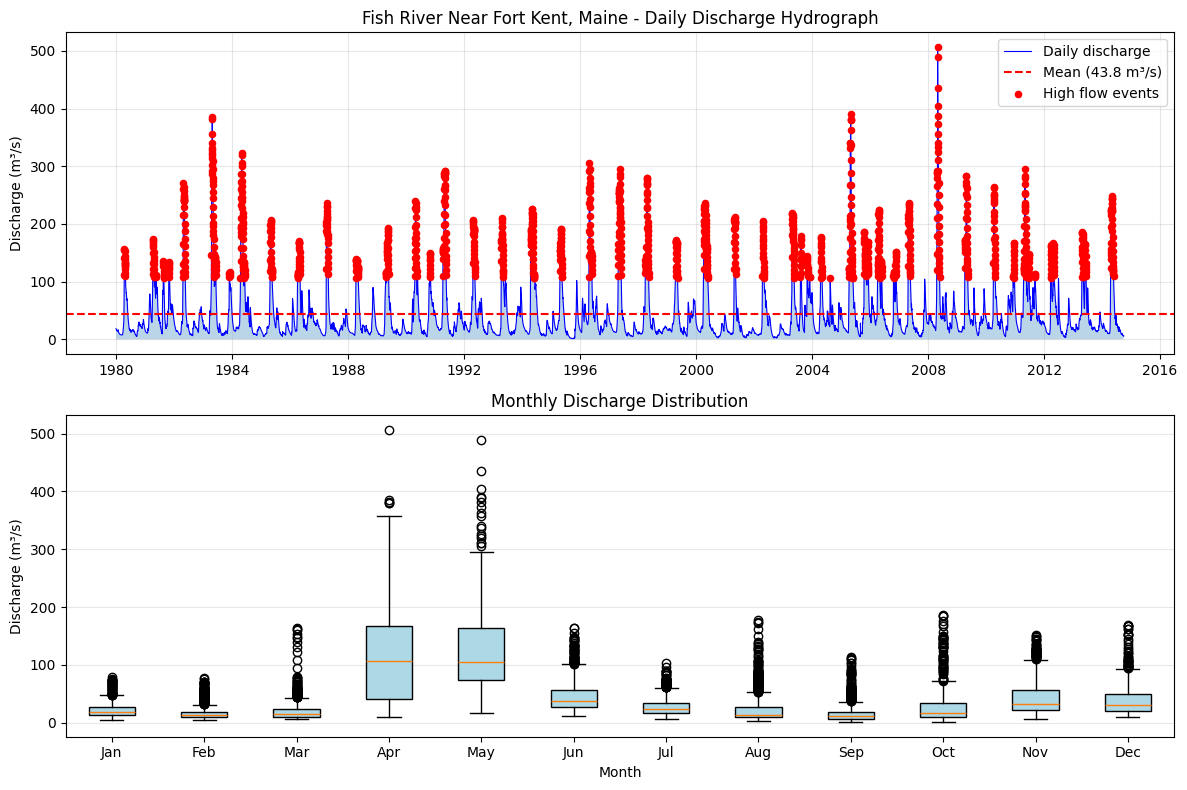


Analysis complete!


In [8]:
# =============================================================================
# CREATE VISUALIZATIONS
# =============================================================================

print("Creating visualizations...")

# Create a figure with 2 subplots stacked vertically
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# --- Plot 1: Hydrograph ---
ax1 = axes[0]

# Plot the discharge time series
ax1.plot(df.index, df[DISCHARGE_COLUMN], 'b-', linewidth=0.8, label='Daily discharge')

# Add mean line
mean_q = stats['Mean discharge (m³/s)']
ax1.axhline(y=mean_q, color='red', linestyle='--', linewidth=1.5,
            label=f'Mean ({mean_q:.1f} m³/s)')

# Add shading under the curve
ax1.fill_between(df.index, 0, df[DISCHARGE_COLUMN], alpha=0.3)

# Mark high flow events
ax1.scatter(high_flow_days.index, high_flow_days[DISCHARGE_COLUMN],
            color='red', s=20, zorder=5, label='High flow events')

# Labels and formatting
ax1.set_ylabel('Discharge (m³/s)')
ax1.set_title(f'{station_name} - Daily Discharge Hydrograph')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- Plot 2: Monthly Box Plot ---
ax2 = axes[1]

# Prepare data for box plot (group by month)
df_temp = df.copy()
df_temp['month'] = df_temp.index.month

# Create box plot data for each month
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
box_data = [df_temp[df_temp['month'] == m][DISCHARGE_COLUMN].dropna().values
            for m in range(1, 13)]

# Create the box plot (use tick_labels instead of deprecated labels)
bp = ax2.boxplot(box_data, tick_labels=month_names, patch_artist=True)

# Color the boxes
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

# Labels and formatting
ax2.set_ylabel('Discharge (m³/s)')
ax2.set_xlabel('Month')
ax2.set_title('Monthly Discharge Distribution')
ax2.grid(True, alpha=0.3, axis='y')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

print()
print("=" * 60)
print("Analysis complete!")
print("=" * 60)

## Step 4: Run the Complete Analysis

Now run your analysis script:

```bash
uv run analyze_discharge.py
```

### Expected Output

You should see:
- Flow statistics printed to the console
- Extreme event identification
- Monthly summary table
- Two output files: `discharge_analysis.png` and `discharge_analysis.pdf`

Open the PNG file to see your hydrograph and monthly distribution plots!

## Understanding the Code

Let's review the key Python concepts used:

| Code | What It Does |
|------|-------------|
| `pd.read_csv(file)` | Loads a CSV file into a DataFrame |
| `pd.to_datetime(column)` | Converts text to date format |
| `df.set_index(column)` | Sets a column as row labels |
| `series.mean()`, `.max()`, `.min()` | Calculate statistics |
| `series.quantile(0.90)` | Find the 90th percentile |
| `df.resample('ME')` | Group data by month |
| `plt.subplots(2, 1)` | Create a figure with 2 plots |
| `ax.plot(x, y)` | Draw a line plot |
| `ax.boxplot(data)` | Create a box plot |
| `plt.savefig(file)` | Save the figure to a file |

### Key Design Patterns

**1. Configuration at the top**
```python
INPUT_FILE = 'data.csv'
DISCHARGE_COLUMN = 'discharge_m3s'
```
Makes adapting the script easy—change settings in one place.

**2. Handling missing data**
```python
Q = df[DISCHARGE_COLUMN].dropna()
```
Always check for and handle missing values before calculations.

**3. Clear section headers**
```python
# =============================================================================
# CALCULATE STATISTICS
# =============================================================================
```
Makes the code easy to navigate and understand.

## Adapting for Your Own Data

To use this script with your own discharge data:

### 1. Check Your Data Format

Your CSV should have at least:
- A date column (any reasonable format)
- A discharge column (numeric values)

### 2. Update the Configuration

```python
INPUT_FILE = 'your_data.csv'
DATE_COLUMN = 'your_date_column_name'
DISCHARGE_COLUMN = 'your_discharge_column_name'
STATION_NAME = 'Your Station Name'
```

### 3. Handle Different Date Formats

If your dates are in a specific format (e.g., European `DD.MM.YYYY`):

```python
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN], format='%d.%m.%Y')
```

Common format codes:
- `%Y-%m-%d` → 2024-01-15
- `%d.%m.%Y` → 15.01.2024
- `%d/%m/%Y` → 15/01/2024
- `%m/%d/%Y` → 01/15/2024

## Common Issues with Real Data

Real hydrological data often has issues. Here's how to handle them:

### Missing Values

```python
# Check how much is missing
missing_pct = df[DISCHARGE_COLUMN].isna().sum() / len(df) * 100
print(f"Missing: {missing_pct:.1f}%")

# Option 1: Drop missing values (what we did)
Q = df[DISCHARGE_COLUMN].dropna()

# Option 2: Interpolate small gaps
df[DISCHARGE_COLUMN] = df[DISCHARGE_COLUMN].interpolate(method='time')
```

### Outliers

```python
# Flag potential outliers (values beyond 3 standard deviations)
mean_q = df[DISCHARGE_COLUMN].mean()
std_q = df[DISCHARGE_COLUMN].std()
outliers = df[abs(df[DISCHARGE_COLUMN] - mean_q) > 3 * std_q]
print(f"Potential outliers: {len(outliers)} days")
```

### Negative Values

```python
# Check for invalid negative discharge
negative = df[df[DISCHARGE_COLUMN] < 0]
if len(negative) > 0:
    print(f"Warning: {len(negative)} negative values found!")
```

## Step 5: Flow Duration Curve

A **flow duration curve (FDC)** is one of the most valuable tools in hydrology. It shows the percentage of time a given discharge is equaled or exceeded.

### Why Flow Duration Curves Matter

| Application | What the FDC Tells You |
|-------------|------------------------|
| **Water supply** | How often can we extract X m³/s? |
| **Hydropower** | What flow is available 90% of the time? |
| **Environmental flows** | What's the natural low-flow regime? |
| **Flood risk** | How often do extreme flows occur? |
| **Catchment comparison** | Is this catchment flashy or stable? |

### Reading the Curve

- **Steep slope** = Flashy catchment (quick response to rainfall, high variability)
- **Gentle slope** = Baseflow-dominated (groundwater fed, stable flows)
- **Q50** = Median flow (exceeded 50% of the time)
- **Q90** = Low flow indicator (exceeded 90% of the time)
- **Q10** = High flow indicator (exceeded only 10% of the time)

Creating Flow Duration Curve...


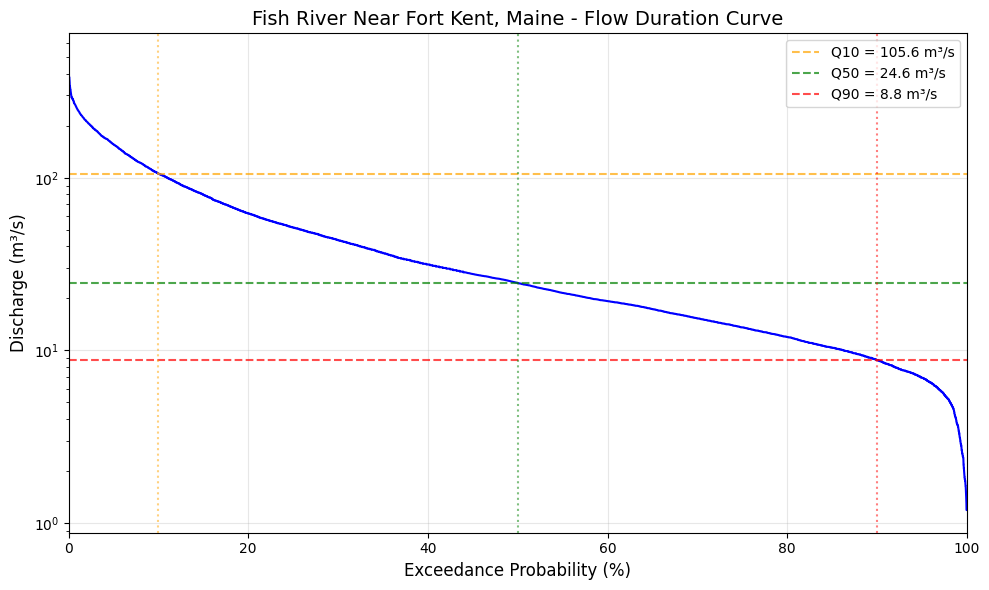


KEY FLOW DURATION VALUES
---------------------------------------------
  Q10 (exceeded 10% of time):     105.6 m³/s  (high flow)
  Q50 (exceeded 50% of time):      24.6 m³/s  (median)
  Q90 (exceeded 90% of time):       8.8 m³/s  (low flow)

  Flow range ratio (Q10/Q90): 12.0
  (Higher ratio = more variable/flashy catchment)


In [9]:
# =============================================================================
# CREATE FLOW DURATION CURVE
# =============================================================================

print("Creating Flow Duration Curve...")

# Get discharge values (excluding NaN)
Q = df[DISCHARGE_COLUMN].dropna()

# Sort discharge values from highest to lowest
sorted_q = np.sort(Q)[::-1]

# Calculate exceedance probability for each value
# Exceedance probability = rank / (n + 1) * 100
n = len(sorted_q)
exceedance_prob = np.arange(1, n + 1) / (n + 1) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the flow duration curve
ax.plot(exceedance_prob, sorted_q, 'b-', linewidth=1.5)

# Add reference lines for key percentiles
q10 = np.percentile(Q, 90)  # Flow exceeded 10% of time
q50 = np.percentile(Q, 50)  # Median flow
q90 = np.percentile(Q, 10)  # Flow exceeded 90% of time

ax.axhline(y=q10, color='orange', linestyle='--', alpha=0.7, label=f'Q10 = {q10:.1f} m³/s')
ax.axhline(y=q50, color='green', linestyle='--', alpha=0.7, label=f'Q50 = {q50:.1f} m³/s')
ax.axhline(y=q90, color='red', linestyle='--', alpha=0.7, label=f'Q90 = {q90:.1f} m³/s')

# Add vertical reference lines
ax.axvline(x=10, color='orange', linestyle=':', alpha=0.5)
ax.axvline(x=50, color='green', linestyle=':', alpha=0.5)
ax.axvline(x=90, color='red', linestyle=':', alpha=0.5)

# Labels and formatting
ax.set_xlabel('Exceedance Probability (%)', fontsize=12)
ax.set_ylabel('Discharge (m³/s)', fontsize=12)
ax.set_title(f'{station_name} - Flow Duration Curve', fontsize=14)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)

# Use log scale for y-axis (common for FDCs)
ax.set_yscale('log')
ax.set_xlim(0, 100)

plt.tight_layout()
plt.show()

# Print key values
print()
print("KEY FLOW DURATION VALUES")
print("-" * 45)
print(f"  Q10 (exceeded 10% of time):  {q10:>8.1f} m³/s  (high flow)")
print(f"  Q50 (exceeded 50% of time):  {q50:>8.1f} m³/s  (median)")
print(f"  Q90 (exceeded 90% of time):  {q90:>8.1f} m³/s  (low flow)")
print()
print(f"  Flow range ratio (Q10/Q90): {q10/q90:.1f}")
print("  (Higher ratio = more variable/flashy catchment)")

> **Understanding the Code:**
> 
> 1. **Sort descending**: `np.sort(Q)[::-1]` - Highest flows first
> 2. **Calculate exceedance**: Each value's rank divided by total count gives probability
> 3. **Log scale**: Y-axis uses logarithmic scale to show low flows clearly
> 4. **Q10/Q90 ratio**: A simple metric for flow variability (values >10 indicate flashy catchments)
>
> **Note on percentile conventions:** In this FDC, Q90 means "flow exceeded 90% of the time" (a low flow). Some sources use Q90 to mean "90th percentile" (a high flow). Always clarify which convention you're using!

---

## Ideas for Further Extension

Now that you have a complete analysis workflow, here are ideas to extend it:

## Troubleshooting

### "FileNotFoundError: aare_discharge_2022_2023.csv"

- Make sure you ran `create_sample_data.py` first
- Check you're in the correct project folder
- Verify the file exists: `ls` (Mac/Linux) or `dir` (Windows)

### "KeyError: 'discharge_m3s'"

- The column name doesn't match your data
- Check your CSV headers: `print(df.columns)`
- Update `DISCHARGE_COLUMN` to match

### Plot looks empty or wrong

- Check that dates were parsed correctly: `print(df.index)`
- Verify data range: `print(df[DISCHARGE_COLUMN].describe())`
- Look for all-NaN data in specific periods

### "SettingWithCopyWarning"

This warning can be ignored for now—it doesn't affect your results. It's about pandas' internal data handling.

## Summary

In this module, you:

✅ Loaded and prepared time series data with pandas  
✅ Calculated key hydrological statistics  
✅ Identified extreme flow events  
✅ Created professional visualizations (hydrograph + monthly boxplots)  
✅ Built a flow duration curve with key percentiles  
✅ Learned how to adapt the script for your own data  

### What You've Built

You now have a reusable discharge analysis workflow:

```
Input: CSV with discharge data
    ↓
Process: Python script
    ↓
Output: Statistics + Hydrograph + Monthly plots + Flow Duration Curve
```

This same pattern applies to most water modelling tasks—load data, process it, visualize results.

---

**Next up:** Explore additional resources and next steps → [Module 5: Resources & Next Steps](05_resources_next_steps.ipynb)